In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import json

In [2]:
# Load dataset
data = pd.read_csv('../data/ENB2012_data_with_columns.csv')

# Check for NaN values and replace or drop them
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

# Define input and output variables
X = data.iloc[:, :-2]
y_hl = data['Heating_Load']
y_cl = data['Cooling_Load']

In [4]:
# Load best parameters from JSON file
with open('../results/tables/best_params.json', 'r') as f:
    best_params = json.load(f)
best_params_hl = best_params['heating_load']
best_params_cl = best_params['cooling_load']

xgb_model_hl = XGBRegressor(**best_params_hl)
xgb_model_cl = XGBRegressor(**best_params_cl)

In [5]:
# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

results_hl = []
results_cl = []

actual_vs_predicted_hl = []
actual_vs_predicted_cl = []

fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_hl, y_test_hl = y_hl.iloc[train_index], y_hl.iloc[test_index]
    y_train_cl, y_test_cl = y_cl.iloc[train_index], y_cl.iloc[test_index]
    
    # Train the models
    xgb_model_hl.fit(X_train, y_train_hl)
    xgb_model_cl.fit(X_train, y_train_cl)
    
    # Predict
    y_pred_hl = xgb_model_hl.predict(X_test)
    y_pred_cl = xgb_model_cl.predict(X_test)
    
    # Collect actual vs predicted values
    actual_vs_predicted_hl.append((y_test_hl, y_pred_hl))
    actual_vs_predicted_cl.append((y_test_cl, y_pred_cl))
    
    # Calculate performance metrics
    mae_hl = mean_absolute_error(y_test_hl, y_pred_hl)
    rmse_hl = np.sqrt(mean_squared_error(y_test_hl, y_pred_hl))
    mape_hl = mean_absolute_percentage_error(y_test_hl, y_pred_hl) * 100
    r2_hl = r2_score(y_test_hl, y_pred_hl)
    
    mae_cl = mean_absolute_error(y_test_cl, y_pred_cl)
    rmse_cl = np.sqrt(mean_squared_error(y_test_cl, y_pred_cl))
    mape_cl = mean_absolute_percentage_error(y_test_cl, y_pred_cl) * 100
    r2_cl = r2_score(y_test_cl, y_pred_cl)
    
    results_hl.append([fold, mae_hl, rmse_hl, mape_hl, r2_hl])
    results_cl.append([fold, mae_cl, rmse_cl, mape_cl, r2_cl])
    
    fold += 1

In [6]:
# Convert results to DataFrames
columns = ['Fold', 'MAE (kW)', 'RMSE (kW)', 'MAPE (%)', 'R-squared']
df_results_hl = pd.DataFrame(results_hl, columns=columns)
df_results_cl = pd.DataFrame(results_cl, columns=columns)

# Calculate averages and standard deviations
summary_hl = df_results_hl.describe().loc[['mean', 'std']]
summary_cl = df_results_cl.describe().loc[['mean', 'std']]

# Add averages and standard deviations to DataFrames
df_results_hl.loc['Avg.'] = summary_hl.loc['mean']
df_results_hl.loc['Std.'] = summary_hl.loc['std']
df_results_cl.loc['Avg.'] = summary_cl.loc['mean']
df_results_cl.loc['Std.'] = summary_cl.loc['std']

# Save results to an Excel file
with pd.ExcelWriter('../results/metrics/performance_metrics.xlsx') as writer:
    df_results_hl.to_excel(writer, sheet_name='Heating Load', index=False)
    df_results_cl.to_excel(writer, sheet_name='Cooling Load', index=False)

In [8]:
# # Plotting Actual vs Predicted for Heating Load
# fig, axes = plt.subplots(5, 2, figsize=(7.5, 10), sharex=True, sharey=True)
# fig.suptitle('Actual vs Predicted Heating Load for 10 Folds', fontsize=10, fontname='Arial')

# for i, (y_test_hl, y_pred_hl) in enumerate(actual_vs_predicted_hl):
#     ax = axes[i // 2, i % 2]
#     ax.plot(y_test_hl.values, label='Actual HL', linestyle='-', marker='o', markersize=3)
#     ax.plot(y_pred_hl, label='Predicted HL', linestyle='--', marker='x', markersize=3)
#     ax.set_title(f'Fold {i + 1}', fontsize=10, fontname='Arial')
#     ax.set_xlabel('Instance Index (II)', fontsize=10, fontname='Arial')
#     ax.set_ylabel('Heating Load (HL) Response', fontsize=10, fontname='Arial')
#     ax.legend(fontsize=8, loc='upper right')

# plt.tight_layout(pad=1, h_pad=1, w_pad=1)
# plt.savefig('../results/figures/actual_vs_predicted_heating_load_10_folds.tif', format='tif', dpi=300)
# plt.show()

In [9]:
# # Plotting Actual vs Predicted for Cooling Load
# fig, axes = plt.subplots(5, 2, figsize=(7.5, 10), sharex=True, sharey=True)
# fig.suptitle('Actual vs Predicted Cooling Load for 10 Folds', fontsize=10, fontname='Arial')

# for i, (y_test_cl, y_pred_cl) in enumerate(actual_vs_predicted_cl):
#     ax = axes[i // 2, i % 2]
#     ax.plot(y_test_cl.values, label='Actual CL', linestyle='-', marker='o', markersize=3)
#     ax.plot(y_pred_cl, label='Predicted CL', linestyle='--', marker='x', markersize=3)
#     ax.set_title(f'Fold {i + 1}', fontsize=10, fontname='Arial')
#     ax.set_xlabel('Instance Index (II)', fontsize=10, fontname='Arial')
#     ax.set_ylabel('Cooling Load (CL) Response', fontsize=10, fontname='Arial')
#     ax.legend(fontsize=8, loc='upper right')

# plt.tight_layout(pad=1, h_pad=1, w_pad=1)
# plt.savefig('../results/figures/actual_vs_predicted_cooling_load_10_folds.tif', format='tif', dpi=300)
# plt.show()

In [8]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(data, title, ylabel, filename):
    fig, axes = plt.subplots(5, 2, figsize=(7.5, 10), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=10, fontname='Arial')

    for i, (y_test, y_pred) in enumerate(data):
        ax = axes[i // 2, i % 2]
        ax.plot(y_test.values, label='Actual', linestyle='-', marker='o', markersize=3)
        ax.plot(y_pred, label='Predicted', linestyle='--', marker='x', markersize=3)
        ax.set_title(f'Fold {i + 1}', fontsize=10, fontname='Arial')
        ax.set_xlabel('Instance Index (II)', fontsize=10, fontname='Arial')
        ax.set_ylabel(ylabel, fontsize=10, fontname='Arial')
        ax.legend(fontsize=8, loc='upper right')

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.tight_layout(pad=1, h_pad=1, w_pad=1)
    plt.savefig(filename, format='tif', dpi=300)
    plt.show()

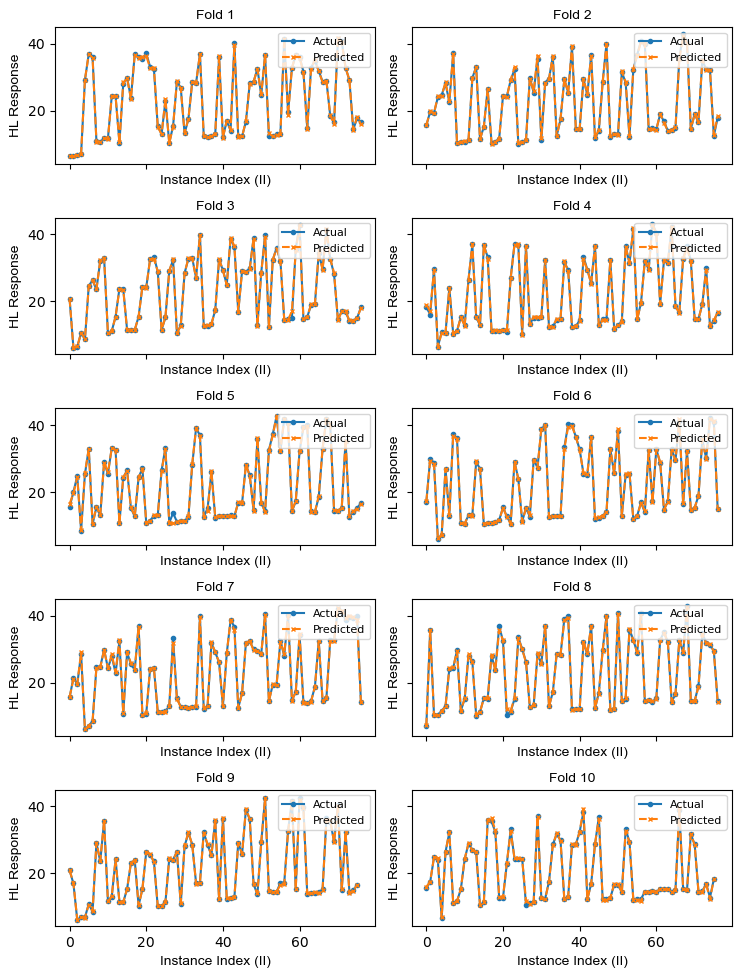

In [9]:
# Plotting Actual vs Predicted for Heating Load
plot_actual_vs_predicted(actual_vs_predicted_hl, None, 'HL Response', '../results/figures/actual_vs_predicted_heating_load_10_folds.tif')

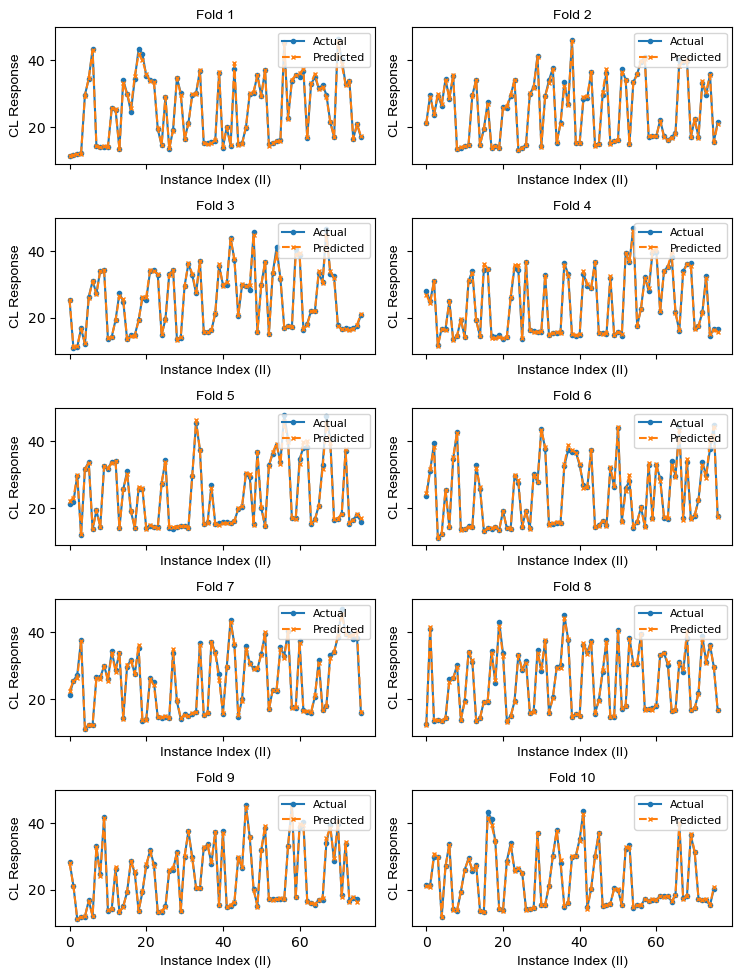

In [10]:
# Plotting Actual vs Predicted for Cooling Load
plot_actual_vs_predicted(actual_vs_predicted_cl, None, 'CL Response', '../results/figures/actual_vs_predicted_cooling_load_10_folds.tif')